--- STEP 1: LOADING DATA 'dataset.xlsx' ---
>> Success: Loaded as Excel.
Data Processed. N = 309 students.

       RAW STATISTICAL RESULTS

[1. Descriptive Statistics]
                          count   mean    std  min   max
ACE_Total_Score           309.0  2.595  2.385  0.0  10.0
Academic_Motivation_Mean  309.0  3.929  0.710  1.0   5.0

[2. Correlation Analysis]
Pearson Correlation (r): -0.12570
Sig. (2-tailed) p-value: 2.71497e-02
Interpretation:          SIGNIFICANT (p < .05)

[3. Linear Regression Model]
           Predictor  Beta (Coef)  Std Error   T-Stat  P-Value
Intercept (Constant)      4.02648    0.05937 67.82282  0.00000
           ACE Score     -0.03742    0.01685 -2.21999  0.02715

Model R-Squared: 0.01580 (Explained Variance)
--------------------------------------------------

Generating Plots...


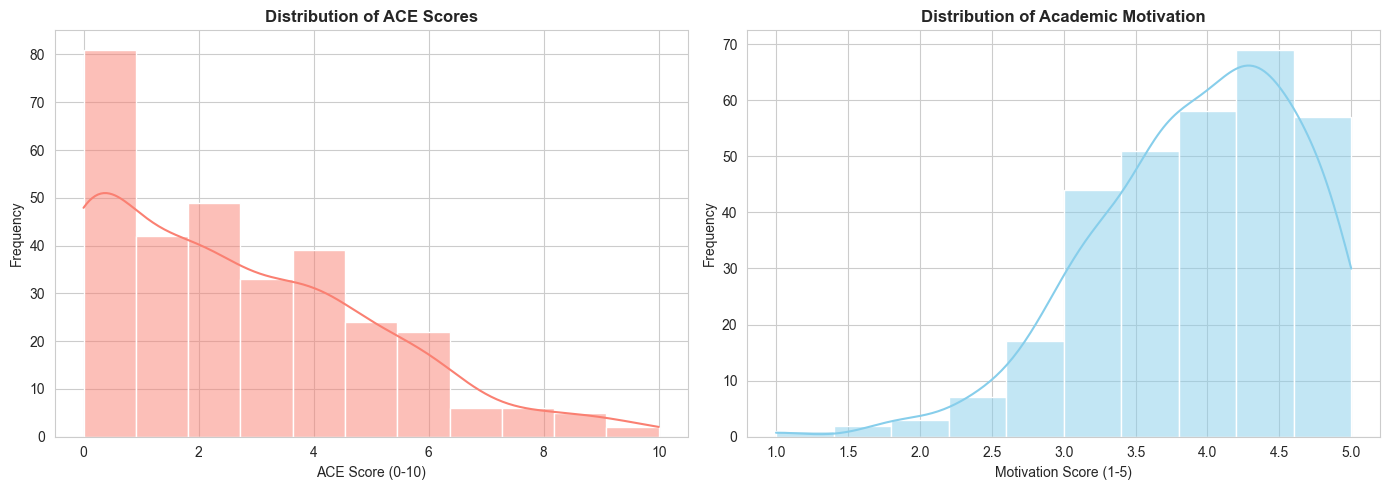

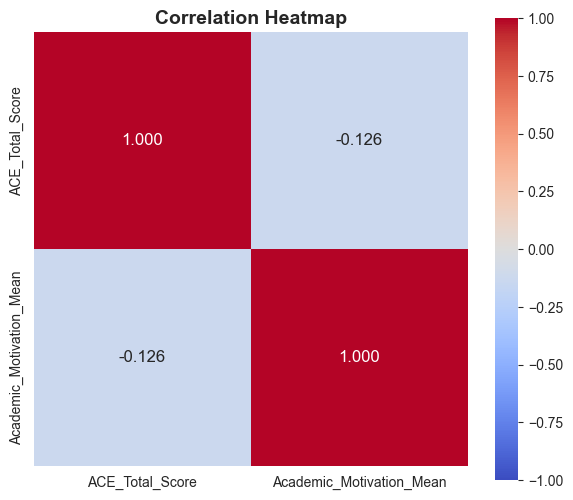

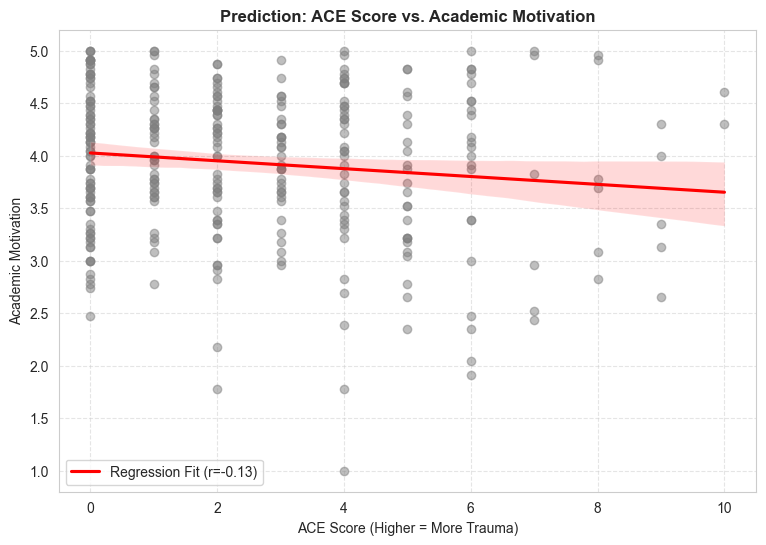


Analysis Complete.


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import statsmodels.api as sm
import warnings
import os

# Set style for plots
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# ==========================================
# 1. ROBUST DATA LOADING
# ==========================================
# Update this filename if yours is different
filename = 'dataset.xlsx' 

print(f"--- STEP 1: LOADING DATA '{filename}' ---")

try:
    # Try reading as Excel (header=1 is crucial for this dataset)
    df = pd.read_excel(filename, header=1, engine='openpyxl')
    print(">> Success: Loaded as Excel.")
except:
    try:
        # Fallback to CSV
        df = pd.read_csv(filename, header=1)
        print(">> Success: Loaded as CSV.")
    except Exception as e:
        print(f"Error: {e}")
        raise ValueError("Could not load file. Please check if 'dataset.xlsx' exists.")

# Clean column names
df.columns = df.columns.str.strip()

# ==========================================
# 2. DATA PROCESSING & SCORING
# ==========================================

# --- A. ACEs Score (Columns 4-13) ---
ace_cols = df.columns[4:14]
# Map Yes/No to 1/0
ace_df = df[ace_cols].replace({'Yes': 1, 'No': 0, 'yes': 1, 'no': 0, 'YES': 1, 'NO': 0})
ace_df = ace_df.apply(pd.to_numeric, errors='coerce')
df['ACE_Total_Score'] = ace_df.sum(axis=1)

# --- B. Academic Motivation ---
ams_cols = [col for col in df.columns if "Why do you go to college?" in col]
ams_df = df[ams_cols].apply(pd.to_numeric, errors='coerce')

# Filter out "Amotivation" items
amotivation_keywords = ["wasting my time", "wonder whether I should continue", "couldn't care less", "can't understand", "don't know"]
motivation_cols = [c for c in ams_cols if not any(k in c for k in amotivation_keywords)]

df['Academic_Motivation_Mean'] = ams_df[motivation_cols].mean(axis=1)

# Clean Data (Drop Missing)
df_clean = df.dropna(subset=['ACE_Total_Score', 'Academic_Motivation_Mean']).copy()
print(f"Data Processed. N = {len(df_clean)} students.")

# ==========================================
# 3. PRINTED RAW STATISTICS (TABLES)
# ==========================================
print("\n" + "="*50)
print("       RAW STATISTICAL RESULTS")
print("="*50)

# --- A. Descriptive Statistics ---
print("\n[1. Descriptive Statistics]")
desc_table = df_clean[['ACE_Total_Score', 'Academic_Motivation_Mean']].describe().T
desc_table = desc_table[['count', 'mean', 'std', 'min', 'max']]
print(desc_table.round(3))

# --- B. Correlation Analysis ---
print("\n[2. Correlation Analysis]")
r_val, p_val = pearsonr(df_clean['ACE_Total_Score'], df_clean['Academic_Motivation_Mean'])

print(f"Pearson Correlation (r): {r_val:.5f}")
print(f"Sig. (2-tailed) p-value: {p_val:.5e}")
if p_val < 0.05:
    print("Interpretation:          SIGNIFICANT (p < .05)")
else:
    print("Interpretation:          Not Significant")

# --- C. Regression Analysis ---
print("\n[3. Linear Regression Model]")
X = sm.add_constant(df_clean['ACE_Total_Score']) # Predictor
Y = df_clean['Academic_Motivation_Mean']         # Outcome
model = sm.OLS(Y, X).fit()

# Create a clean summary table
reg_summary = pd.DataFrame({
    'Predictor': ['Intercept (Constant)', 'ACE Score'],
    'Beta (Coef)': model.params.values,
    'Std Error': model.bse.values,
    'T-Stat': model.tvalues.values,
    'P-Value': model.pvalues.values
})

print(reg_summary.round(5).to_string(index=False))
print(f"\nModel R-Squared: {model.rsquared:.5f} (Explained Variance)")
print("-" * 50)

# ==========================================
# 4. VISUALIZATIONS
# ==========================================
print("\nGenerating Plots...")

# FIGURE 1: DESCRIPTIVE HISTOGRAMS
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ACE Distribution
sns.histplot(df_clean['ACE_Total_Score'], kde=True, ax=axes[0], color='salmon', bins=11)
axes[0].set_title('Distribution of ACE Scores', fontweight='bold')
axes[0].set_xlabel('ACE Score (0-10)')
axes[0].set_ylabel('Frequency')

# Motivation Distribution
sns.histplot(df_clean['Academic_Motivation_Mean'], kde=True, ax=axes[1], color='skyblue', bins=10)
axes[1].set_title('Distribution of Academic Motivation', fontweight='bold')
axes[1].set_xlabel('Motivation Score (1-5)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# FIGURE 2: CORRELATION HEATMAP
plt.figure(figsize=(7, 6))
corr_matrix = df_clean[['ACE_Total_Score', 'Academic_Motivation_Mean']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, 
            fmt='.3f', square=True, annot_kws={"size": 12})
plt.title('Correlation Heatmap', fontweight='bold', fontsize=14)
plt.show()

# FIGURE 3: REGRESSION SCATTER PLOT
plt.figure(figsize=(9, 6))
sns.regplot(x='ACE_Total_Score', y='Academic_Motivation_Mean', data=df_clean,
            scatter_kws={'alpha':0.5, 'color': 'gray'}, 
            line_kws={'color': 'red', 'label': f'Regression Fit (r={r_val:.2f})'})

plt.title('Prediction: ACE Score vs. Academic Motivation', fontweight='bold')
plt.xlabel('ACE Score (Higher = More Trauma)')
plt.ylabel('Academic Motivation')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

print("\nAnalysis Complete.")

--- STEP 1: LOADING DATA ---
File: Adverse Childhood Experience As A Predictor Of Academic Motivation Among Tertiary Schools Students in FEU Diliman (Responses).xlsx - Form Responses 1.csv
Error loading file: [Errno 2] No such file or directory: 'Adverse Childhood Experience As A Predictor Of Academic Motivation Among Tertiary Schools Students in FEU Diliman (Responses).xlsx - Form Responses 1.csv'
>> Warning: Loaded 'dataset.xlsx' instead.
Data Processed. N = 309 students.

       RAW STATISTICAL RESULTS

[1. Descriptive Statistics]
                          count   mean    std  min   max
ACE_Total_Score           309.0  2.595  2.385  0.0  10.0
Academic_Motivation_Mean  309.0  3.929  0.710  1.0   5.0

[2. Reliability Analysis (Cronbach's Alpha)]
ACE Scale (10 items):          0.767
Motivation Scale (23 items): 0.944

[3. Correlation Analysis]
Pearson r: -0.12570
P-Value:   2.71497e-02 (Significant)

[4. Linear Regression Analysis]
Predictor     Beta  Std Err   T-Stat  P-Value
Intercep

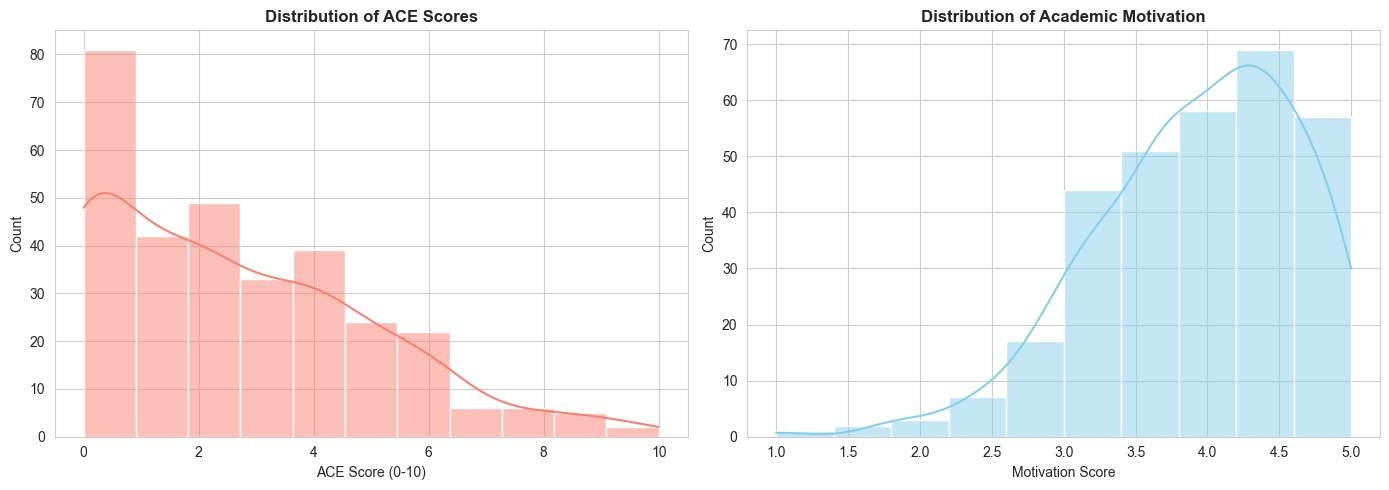

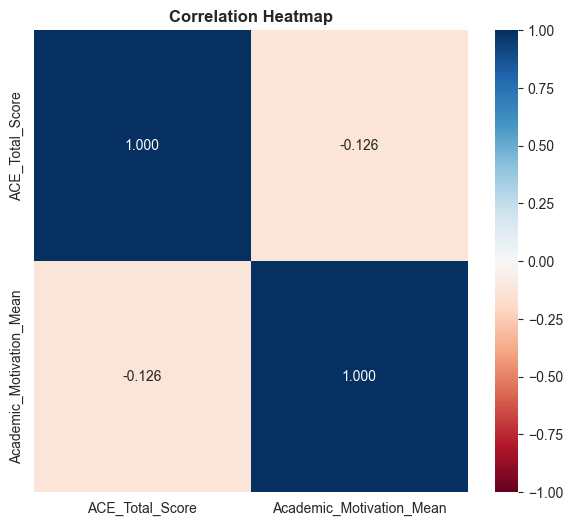

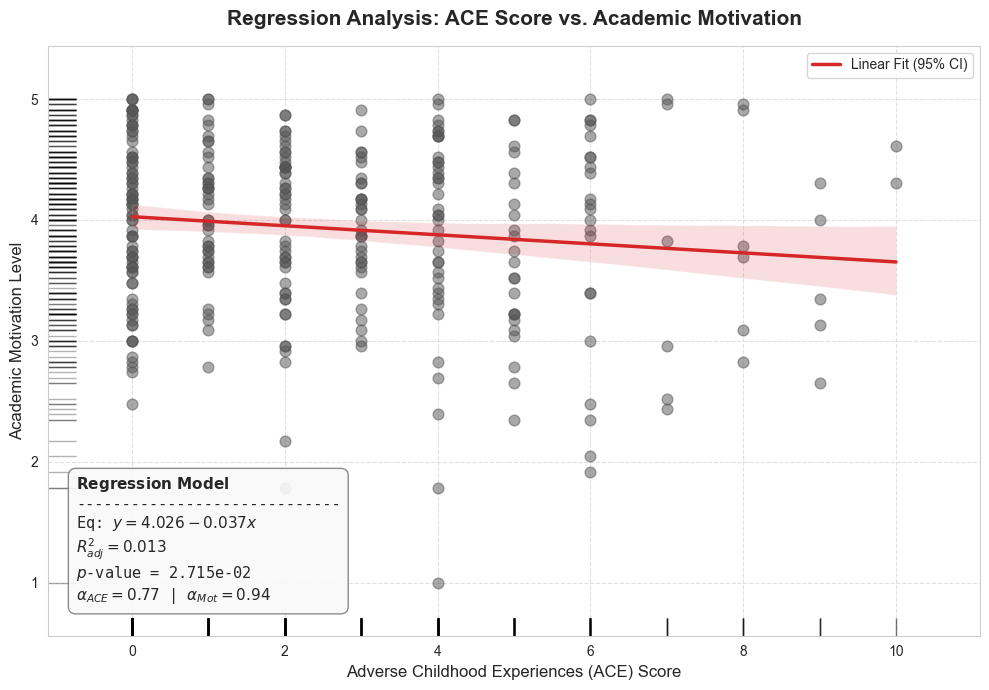

Analysis Complete.


In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import statsmodels.api as sm
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# ==========================================
# 1. LOAD THE CORRECT DATASET
# ==========================================
# Use the specific filename for the ACEs study
filename = 'Adverse Childhood Experience As A Predictor Of Academic Motivation Among Tertiary Schools Students in FEU Diliman (Responses).xlsx - Form Responses 1.csv'

print(f"--- STEP 1: LOADING DATA ---")
print(f"File: {filename}")

try:
    # Try reading as Excel/CSV with header=1 (Row 2 is usually the header for Google Forms)
    try:
        df = pd.read_excel(filename, header=1, engine='openpyxl')
    except:
        df = pd.read_csv(filename, header=1)
    
    print(">> Success: Data Loaded.")
    
    # Clean Columns: Convert to string and strip whitespace
    df.columns = df.columns.astype(str).str.strip()

except Exception as e:
    print(f"Error loading file: {e}")
    # Fallback to 'dataset.xlsx' if the long name isn't found (just in case)
    try:
        df = pd.read_excel('dataset.xlsx', header=1, engine='openpyxl')
        df.columns = df.columns.astype(str).str.strip()
        print(">> Warning: Loaded 'dataset.xlsx' instead.")
    except:
        raise ValueError("Could not load any data file.")

# ==========================================
# 2. DATA PROCESSING
# ==========================================

# --- A. ACEs Score (Columns 4-13) ---
# Select columns by index (Question 1 starts at index 4)
ace_cols = df.columns[4:14]
# Map Yes/No to 1/0
ace_df = df[ace_cols].replace({'Yes': 1, 'No': 0, 'yes': 1, 'no': 0, 'YES': 1, 'NO': 0})
ace_df = ace_df.apply(pd.to_numeric, errors='coerce')
df['ACE_Total_Score'] = ace_df.sum(axis=1)

# --- B. Academic Motivation ---
# Find columns containing the motivation question
ams_cols = [col for col in df.columns if "Why do you go to college?" in col]
ams_df = df[ams_cols].apply(pd.to_numeric, errors='coerce')

# Filter out "Amotivation" items
amotivation_keywords = ["wasting my time", "wonder whether I should continue", "couldn't care less", "can't understand", "don't know"]
motivation_cols = [c for c in ams_cols if not any(k in c for k in amotivation_keywords)]

df['Academic_Motivation_Mean'] = ams_df[motivation_cols].mean(axis=1)

# Drop rows with missing values
df_clean = df.dropna(subset=['ACE_Total_Score', 'Academic_Motivation_Mean']).copy()
print(f"Data Processed. N = {len(df_clean)} students.")

# ==========================================
# 3. STATISTICAL OUTPUT
# ==========================================

# --- A. Descriptive Statistics ---
print("\n" + "="*50)
print("       RAW STATISTICAL RESULTS")
print("="*50)
print("\n[1. Descriptive Statistics]")
desc = df_clean[['ACE_Total_Score', 'Academic_Motivation_Mean']].describe().T
print(desc[['count', 'mean', 'std', 'min', 'max']].round(3))

# --- B. Reliability Analysis ---
def calculate_cronbach_alpha(df_items):
    item_variances = df_items.var(axis=0, ddof=1).sum()
    total_variance = df_items.sum(axis=1).var(ddof=1)
    n_items = df_items.shape[1]
    if total_variance == 0: return 0.0
    return (n_items / (n_items - 1)) * (1 - (item_variances / total_variance))

alpha_ace = calculate_cronbach_alpha(ace_df.loc[df_clean.index])
alpha_motivation = calculate_cronbach_alpha(ams_df[motivation_cols].loc[df_clean.index])

print("\n[2. Reliability Analysis (Cronbach's Alpha)]")
print(f"ACE Scale (10 items):          {alpha_ace:.3f}")
print(f"Motivation Scale ({len(motivation_cols)} items): {alpha_motivation:.3f}")

# --- C. Correlation Analysis ---
print("\n[3. Correlation Analysis]")
r_val, p_val = pearsonr(df_clean['ACE_Total_Score'], df_clean['Academic_Motivation_Mean'])
print(f"Pearson r: {r_val:.5f}")
print(f"P-Value:   {p_val:.5e} ({'Significant' if p_val < 0.05 else 'Not Sig'})")

# --- D. Regression Analysis ---
print("\n[4. Linear Regression Analysis]")
X = sm.add_constant(df_clean['ACE_Total_Score'])
Y = df_clean['Academic_Motivation_Mean']
model = sm.OLS(Y, X).fit()

# Extract Stats
intercept = model.params['const']
slope = model.params['ACE_Total_Score']

reg_summary = pd.DataFrame({
    'Predictor': ['Intercept', 'ACE Score'],
    'Beta': model.params.values,
    'Std Err': model.bse.values,
    'T-Stat': model.tvalues.values,
    'P-Value': model.pvalues.values
})
print(reg_summary.round(5).to_string(index=False))
print(f"\nModel R-Squared: {model.rsquared:.5f}")
print("-" * 50)


# ==========================================
# 4. VISUALIZATIONS
# ==========================================
print("\nGenerating Plots...")

# Plot 1: Histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(df_clean['ACE_Total_Score'], kde=True, ax=axes[0], color='salmon', bins=11)
axes[0].set_title('Distribution of ACE Scores', fontweight='bold')
axes[0].set_xlabel('ACE Score (0-10)')
sns.histplot(df_clean['Academic_Motivation_Mean'], kde=True, ax=axes[1], color='skyblue', bins=10)
axes[1].set_title('Distribution of Academic Motivation', fontweight='bold')
axes[1].set_xlabel('Motivation Score')
plt.tight_layout()
plt.show()

# Plot 2: Correlation Heatmap
plt.figure(figsize=(7, 6))
corr_matrix = df_clean[['ACE_Total_Score', 'Academic_Motivation_Mean']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdBu', vmin=-1, vmax=1, center=0, fmt='.3f')
plt.title('Correlation Heatmap', fontweight='bold')
plt.show()

# Plot 3: Enhanced Regression Plot
plt.figure(figsize=(10, 7))
sns.regplot(x='ACE_Total_Score', y='Academic_Motivation_Mean', data=df_clean,
            scatter_kws={'alpha':0.5, 'color': '#555555', 's':60, 'label':'Student Data'}, 
            line_kws={'color': '#D62728', 'linewidth': 2.5, 'label':'Linear Fit (95% CI)'},
            ci=95)
sns.rugplot(data=df_clean, x='ACE_Total_Score', y='Academic_Motivation_Mean', 
            height=0.03, color='black', alpha=0.3)

equation_text = (
    f"$\\mathbf{{Regression\\ Model}}$\n"
    f"-----------------------------\n"
    f"Eq: $y = {intercept:.3f} {slope:+.3f}x$\n"
    f"$R^2_{{adj}} = {model.rsquared_adj:.3f}$\n"
    f"$p$-value = {p_val:.3e}\n"
    f"$\\alpha_{{ACE}} = {alpha_ace:.2f}$ | $\\alpha_{{Mot}} = {alpha_motivation:.2f}$"
)

plt.gca().text(0.03, 0.05, equation_text, transform=plt.gca().transAxes, 
               fontsize=11, fontfamily='monospace', verticalalignment='bottom',
               bbox=dict(boxstyle='round,pad=0.5', facecolor='#F9F9F9', edgecolor='gray', alpha=0.9))

plt.title('Regression Analysis: ACE Score vs. Academic Motivation', fontweight='bold', fontsize=15, pad=15)
plt.xlabel('Adverse Childhood Experiences (ACE) Score', fontsize=12)
plt.ylabel('Academic Motivation Level', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("Analysis Complete.")